In [1]:
### run the script from the figures_code directory
import os
import sys
os.chdir('../')
import pandas as pd
import numpy as np
import seaborn as sns
import re
import scipy.io as sio
import matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from importlib import reload
from scipy import stats
from scipy.stats import zscore
from glob import glob
from Bio.Seq import Seq
from matplotlib.patches import Rectangle

from functions import parsing
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import genomic_data_handling as gdh
from functions import params
from functions import general_functions as gf

In [2]:
LAB_WT_NORM = params.LAB_WT_NORM
tf_sumprom = params.TF_SUMPROM
tf_zscore_sp = tf_sumprom.apply(zscore, nan_policy='omit')
GP = params.GP
libs = params.LIBS_INFO.set_index('Number')
all_tf_coop = params.ALL_TF_COOP
RES_PATH = params.RES_PATH
MNASE = params.MNASE
MNASE_ddmsn =  params.MNASE_ddmsn
ATAC =  params.ATAC
ATAC_ddmsn =  params.ATAC_ddmsn


## (A) Msn2 v DBD binding in the genome

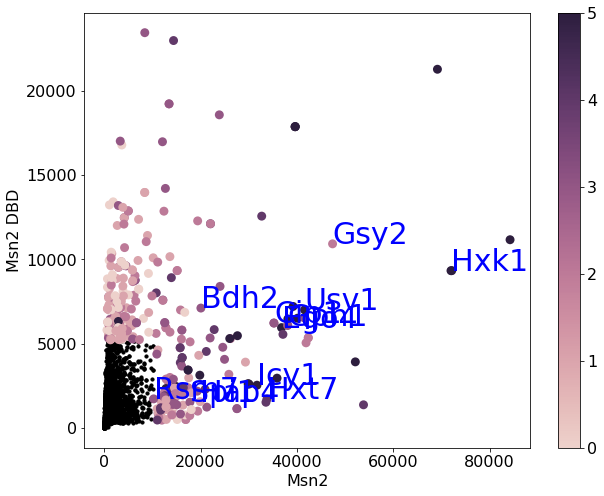

In [3]:
tfa = 'Msn2'
tfb = 'Msn2_DBD'
mot = 'AGGGG'
prom_length = 1000
thresh = 2
n_mots = []
genes = ['Cip1','Ego4','Gsy2','Hxt7','Icy1','Rsm7','Bdh2','Gph1','Hxk1','Spi1','Usv1','Hap4']
gene_ids = []
for gene in genes:
    gene_ids.append(np.where(GP.index==gene.upper())[0][0])
prom_ids = gdh.comb_proms(tfa,tfb,tf_zscore_sp, thresh)
prom_ids = list(set(list(prom_ids)+gene_ids))
for prom in prom_ids:
    seq = gdh.get_seq(prom,prom_length)
    n_mots.append(len(gdh.find_motif_loc(seq,mot)))
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.scatter(tf_sumprom['Msn2'],tf_sumprom['Msn2_DBD'],c='k',s=10)
cm = sns.cubehelix_palette(as_cmap=True)
plt.scatter(tf_sumprom['Msn2'][set(list(prom_ids)+gene_ids)],tf_sumprom['Msn2_DBD'][set(list(prom_ids)+gene_ids)],c=n_mots,s=80,vmax=5,cmap=cm,linewidths=0)
plt.colorbar()
plt.xlabel('Msn2')
plt.ylabel('Msn2 DBD')
x = tf_sumprom.loc[gene_ids,tfa].values
y = tf_sumprom.loc[gene_ids,tfb].values
for i, txt in enumerate(genes):
    plt.annotate(txt, (x[i], y[i]),size=30,c='b')

## (B) Msn2 signal and motif location on libraries

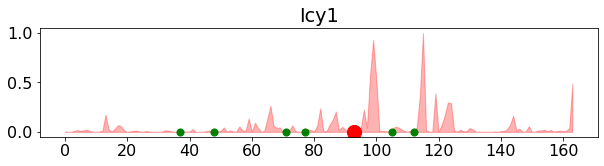

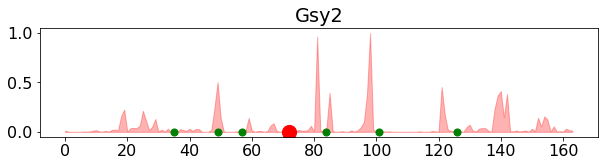

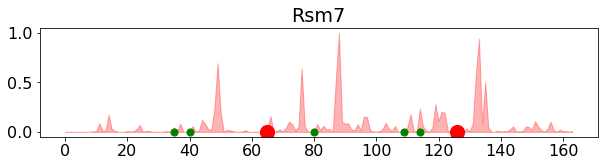

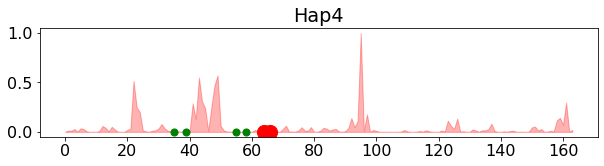

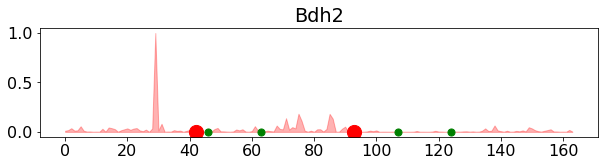

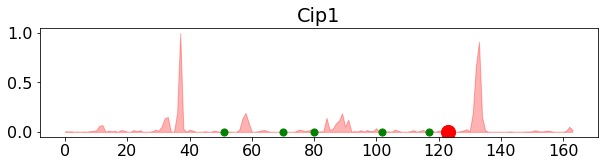

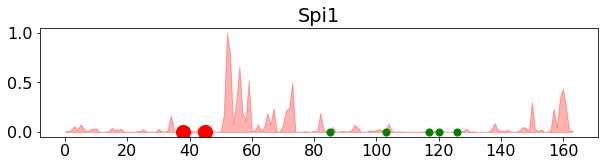

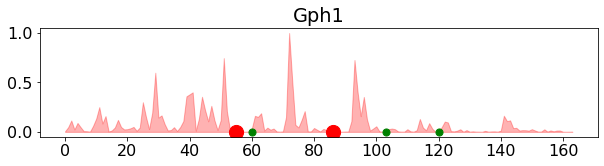

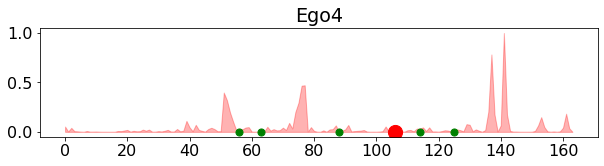

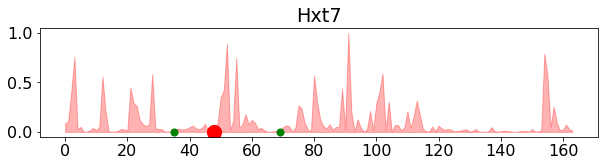

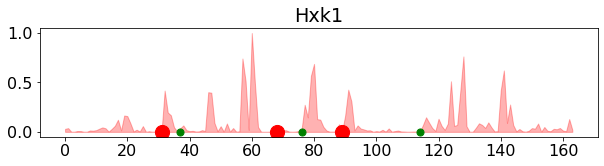

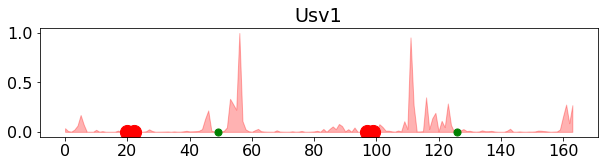

In [4]:
lib_size = 164
prom_length = 1000
tf = 'Msn2'
tf_no_num = 'Msn'
tf_libs = [i for i,x in enumerate(libs['Relevant_factors']) if tf_no_num in x]
rel_libs = libs.iloc[tf_libs,:]
for lib in rel_libs.index:
    lib_info = dp.get_lib_info(lib)
    gene = lib_info['gene']
    lib_start = lib_info['start_position']
    g_start,g_end = int(GP.loc[gene.upper()]['TSS_stein_Start']),int(GP.loc[gene.upper()]['TSS_stein_End'])
    chromosome = int(GP.loc[gene.upper()]['Chromosome'])
    if g_start < g_end:
        curr_signal = LAB_WT_NORM[tf][chromosome-1][g_start-prom_length+lib_start:
                                                      g_start-prom_length+lib_start+lib_size]
        lib_start_pos = g_start-prom_length+lib_start
        lib_end_pos =  g_start-prom_length+lib_start+lib_size
    else:
        curr_signal = LAB_WT_NORM[tf][chromosome-1][g_start+prom_length-lib_start:
                                                      g_start+prom_length-lib_start-lib_size:-1]
        lib_start_pos =  g_start+prom_length-lib_start
        lib_end_pos =  g_start+prom_length-lib_start-lib_size
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    ax.fill_between(range(len(curr_signal)),np.squeeze(curr_signal/np.max(curr_signal)), color='r',alpha=0.3)
    tf_mot_pos = lto.get_tf_mot_pos(tf,lib)
    non_tf_mot_pos = lto.non_tf_mot_pos(tf,lib)
    x_tf = np.array(lib_info['mut_loc'])[tf_mot_pos]
    y_tf = np.zeros(len(np.array(lib_info['mut_loc'])[tf_mot_pos]))
    plt.scatter(x_tf,y_tf,s=200,c='r')
    x_non_tf = np.array(lib_info['mut_loc'])[non_tf_mot_pos]
    y_non_tf = np.zeros(len(np.array(lib_info['mut_loc'])[non_tf_mot_pos]))
    plt.scatter(x_non_tf,y_non_tf,s=50,c='g')
    plt.title(lib_info['gene'])


## (C) Msn2 region binding - wt vs. own motifs

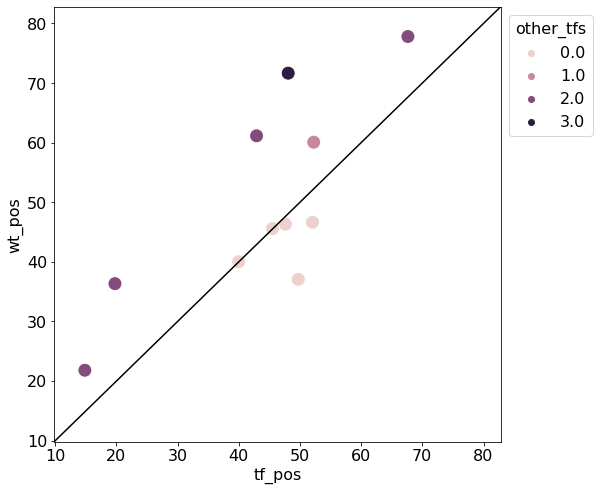

In [5]:
tp = '180'
wanted_exps = [13,26]
thresh = 10
tf = 'Msn2'
files = np.sort(dp.find_tf_files(tf))
to_perc = 100
wt_res = []
tf_res = []
lib_name = []
exp_num = []
other_tf_mot_bound = []
for i,m_exp in enumerate(wanted_exps):
    for file in files:
        _,lib_num,exp = file.split('.')[0].split('_')
        tf_mot_pos = lto.get_tf_mot_pos(tf,lib_num)
        non_tf_mot_pos = lto.non_tf_mot_pos(tf,lib_num)
        if (len(tf_mot_pos) > 0) & (int(exp)==m_exp): # change between == 1 to > 1 to change library type
            lib_info = dp.get_lib_info(lib_num)
            norm_df = lto.norm_res_data(tf, lib_num, exp, None, occ=True)
            wt_r,_ = lto.get_values_by_wt_pos(range(0,len(lib_info['mut_loc'])),norm_df,lib_num)
            wt_res.append(dp.mean_over_bio_reps(wt_r)[tp].values[0]*to_perc)
            tf_r,_ = lto.get_values_by_wt_pos(tf_mot_pos,norm_df,lib_num)
            tf_res.append(dp.mean_over_bio_reps(tf_r)[tp].values[0]*to_perc)
            curr_res,_ = lto.only_pos_intact_change_calc(tf,lib_num,exp,None,occ=True)
            other_tf_mot_bound.append(np.sum(curr_res.iloc[:,non_tf_mot_pos].loc[tp,:]*to_perc>thresh))
            lib_name.append(lib_info['gene'])
            exp_num.append(exp)
wn_cols = ['tf_pos','wt_pos','lib','exp','other_tfs']
df = pd.DataFrame([tf_res,wt_res,lib_name,exp_num,other_tf_mot_bound]).T
df.columns = wn_cols
df = df.groupby('lib').mean()
df['other_tfs'] = df['other_tfs'].apply(np.ceil)
fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=df,x='tf_pos',y='wt_pos',hue='other_tfs',s=200)
min_lim = min(df.iloc[:,:2].min()-5)
max_lim = max(df.iloc[:,:2].max()+5)
ax.set_xlim(min_lim, max_lim)
ax.set_ylim(min_lim, max_lim)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.axline((0, 0), slope=1, c='k')   

## (D) Msn2 occupancy on all of the EGO4 GSY2 sequences

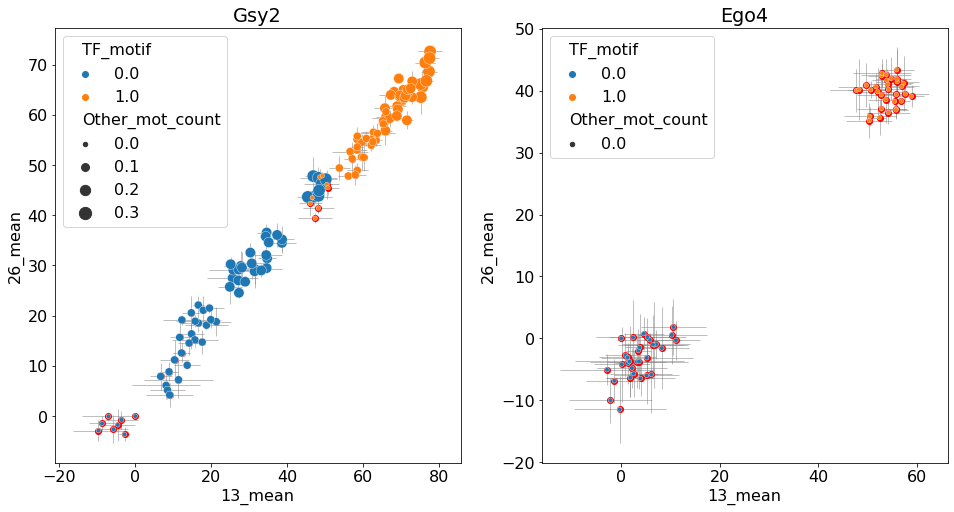

In [6]:
tf = 'Msn2'
tf_split =  re.findall('\d*\D+',tf)[0]
exps = ['13', '26']
tp='180'
effect_tresh = 0.1 
libs = ['32', '78']
exp_num='26'

fig, axes = plt.subplots(1,2, figsize=(16,8))
for lib_i, lib_num in enumerate(libs):
    lib_info = dp.get_lib_info(lib_num) # get library information
    
    norm_df = lto.convert_fc_to_occ(lto.combine_2_exps(tf, lib_num, tp, exps, norm_to=None))
    single_pos_effect,_ = lto.only_pos_intact_change_calc(tf, lib_num, exp_num=None, norm_to=None, occ=None, norm_df=norm_df)
    tf_pos = [i for i,curr_tf_mut in enumerate(lib_info['mut_by_tf']) if tf_split in curr_tf_mut]
    effective_pos = np.where(single_pos_effect.loc[tp] > effect_tresh)[0]

    other_tf_pos=[]
    if len(effective_pos)!=len(tf_pos):
        for pos in tf_pos:
            if pos in effective_pos:
                effective_pos = np.delete(effective_pos, np.where(effective_pos==pos)[0])
        other_tf_pos = effective_pos

    wt_var_seq = ''.join(lib_info['wt_at_var_loc']) # wt seq
    mut_var_seq = lto.get_mut_var(lib_num) # mutated seq

    norm_df = pd.DataFrame()
    for exp_num in exps:
        curr_exp_df_mean = dp.mean_over_bio_reps(lto.norm_res_data(tf, lib_num, exp_num, norm_to=None, occ=True))*100
        curr_exp_df_mean = curr_exp_df_mean[tp].to_frame()
        curr_exp_df_mean = curr_exp_df_mean.add_suffix('_mean')        
        file_name = tf + '_' + str(lib_num) + '_' + str(exp_num) + '.csv'  # looking for the relevant results file based on our system ('tf_libnum_exp.csv')
        norm_res = dp.norm_reads(pd.read_csv(os.path.join(RES_PATH, file_name), index_col=0))  # reading current result table into pd dataframe
        sample_filt_norm, _ = dp.rm_samples(tf, lib_num, exp_num, norm_res)        
        log2_norm = dp.res_log2(sample_filt_norm)
        sample_info = dp.get_samp_info(log2_norm)
        norm_tp_0 = dp.norm_to_tp_0(log2_norm, sample_info)
        norm_uncut = lto.norm_non_cut(lib_num, norm_tp_0, None)
        occ = lto.convert_fc_to_occ(norm_uncut) * 100
        sample_info = dp.get_samp_info(occ)
        curr_exp_df_sem = dp.mean_over_bio_reps(dp.sem_bio_rep_tps(occ, sample_info)) 
        curr_exp_df_sem = curr_exp_df_sem[tp].to_frame()
        curr_exp_df_sem = curr_exp_df_sem.add_suffix('_sem')
        curr_exp_df = pd.concat([curr_exp_df_mean, curr_exp_df_sem], axis=1)
        curr_exp_df.columns = [exp_num+'_'+'mean', exp_num+'_'+'sem']
        norm_df = pd.concat([norm_df, curr_exp_df],axis=1)

    seqs = norm_df.index # library sequences
    all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences spli
    tf_intact_motif_seqs = np.zeros((len(seqs),len(tf_pos)))
    for i, pos in enumerate(tf_pos):
        tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    norm_df['TF_motif'] = np.sum(tf_intact_motif_seqs, axis=1)

    other_tf_mot_count = np.zeros((len(seqs),len(other_tf_pos)))
    for i, pos in enumerate(other_tf_pos):
        other_tf_mot_count[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    norm_df['Other_mot_count'] = np.sum(other_tf_mot_count, axis=1)
    
    ax=sns.scatterplot(data=norm_df, x=exps[0]+'_'+'mean', y=exps[1]+'_'+'mean', hue='TF_motif',
                       size=norm_df['Other_mot_count']/10, sizes=(20,150),zorder=20, ax=axes.ravel()[lib_i])
    
    ax.errorbar(norm_df[exps[0]+'_'+'mean'], norm_df[exps[1]+'_'+'mean'], xerr=norm_df[exps[0]+'_'+'sem'],
                 yerr=norm_df[exps[1]+'_'+'sem'],ecolor='grey',elinewidth=0.5, color='r', fmt='o')

    
    ax.set_title(lib_info['gene'])

## (E) Msn2 motif meta profil (MNase-seq and ATAC-seq)

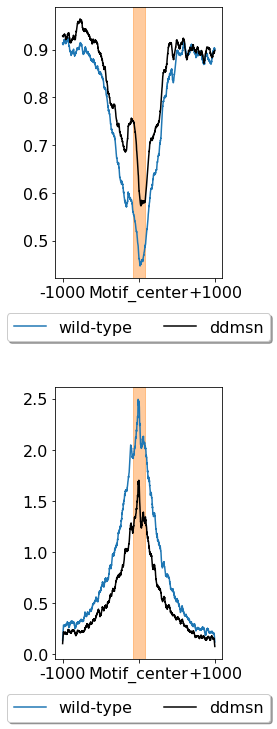

In [7]:
tf='Msn2'
group_size = 200
edge = 1000
lib_len = 164
# mean repeats of MNAse and ATAC
chr_num = 16
datasets = [MNASE, MNASE_ddmsn, ATAC, ATAC_ddmsn]
mean_dataset = [{}, {}, {}, {}]
for dataset_i, dataset in enumerate(datasets):
    for curr_chr in range(chr_num):
        mean_dataset[dataset_i][curr_chr] = np.mean([dataset[curr_chr]['rep1'],dataset[curr_chr]['rep2']],axis=0)
titles = ['MNase','MNase_ddmsn','ATAC', 'ATAC_ddmsn']
nuc_data = dict(zip(titles, mean_dataset))

tf_df = params.MOT_GENOMIC_DATA.query("tf==@tf") # get tf motifs in promoters
tf_df = tf_df.drop_duplicates(['chr_num','mot_start_i']) # remove bidirectional promoters
tf_sorted_df = tf_df.sort_values(by='ChEC', ascending=False) # sort by binding 

fig, axes = plt.subplots(2,1,figsize=(3,12))
plt.subplots_adjust(hspace = 0.4)      

datasets_names = ['MNase', 'ATAC']
for dataset_i, dataset in enumerate(datasets_names):
    wt_data = nuc_data[dataset]
    data_ddmsn = nuc_data[dataset+'_ddmsn']
    curr_group_data = tf_sorted_df.iloc[0:group_size] # get top 200 motifs   
    wt_mean = np.empty((group_size,edge*2))
    ddmsn_mean = np.empty((group_size,edge*2))
    for row_i in range(group_size):
        curr_row = curr_group_data.iloc[row_i,:]
        mot_center = curr_row['mot_start_i'] + int(np.round(len(curr_row['mot_seq'])/2))
        wt_signal= np.log2(wt_data[curr_row['chr_num']][mot_center-edge:mot_center+edge] +1)
        ddmsn_signal = np.log2(data_ddmsn[curr_row['chr_num']][mot_center-edge:mot_center+edge] +1)
        if curr_row['mot_direction' ] == 0: # adjust signal orientation
            wt_signal = np.flip(wt_signal)
            ddmsn_signal = np.flip(ddmsn_signal)

        if dataset == 'ATAC':
            wt_signal = gf.smooth(wt_signal, 20)
            ddmsn_signal = gf.smooth(ddmsn_signal,20)
        wt_mean[row_i,:] = wt_signal
        ddmsn_mean[row_i,:] = ddmsn_signal
    
    fc_mat = wt_mean-ddmsn_mean # calculate fold change

    ax = axes.ravel()[dataset_i]
    sns.lineplot(x=range(edge*2),y=np.nanmean(wt_mean,axis=0), label='wild-type', ax=ax)
    sns.lineplot(x=range(edge*2),y=np.nanmean(ddmsn_mean,axis=0),label='ddmsn',color='k', ax=ax)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=2)
    ax.set_xticks(np.arange(0,edge*2+1,edge), labels=['-'+str(edge), 'Motif_center', '+'+str(edge)])
    y_lim = ax.get_ylim()
    ax.add_patch(Rectangle((edge-lib_len/2, y_lim[0]), lib_len, abs(y_lim[0])+ abs(y_lim[1]), color='C1', alpha=0.4))    

## (F) GSY2 library nucleosome profile

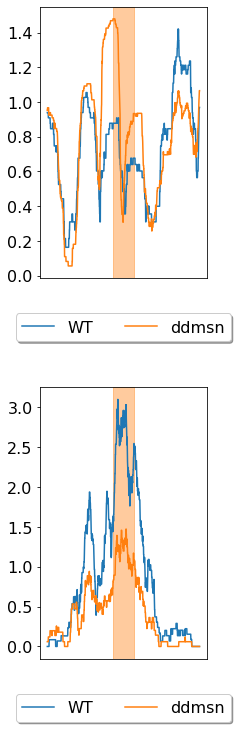

In [8]:
tf= 'Msn2'
lib_num = '32'
lib_len = 164
edge=500
prom_len=1000

fig, axes = plt.subplots(2,1, figsize=(3,12))
plt.subplots_adjust(hspace = 0.4)
labels = ['WT', 'ddmsn']

lib_info = dp.get_lib_info(lib_num)
gene = lib_info['gene'].upper()
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])   

#libs locs
curr_lib_locs = params.LIB_LOCS.loc[int(lib_num)]
curr_chr = curr_lib_locs['Chromosome']
context_start_i = curr_lib_locs['Lib_1kb_start'] + edge  
context_end_i = curr_lib_locs['Lib_1kb_end'] - edge
lib_start_id = curr_lib_locs['Lib_start']
lib_end_id = curr_lib_locs['Lib_end']

datasets_names = ['MNase', 'ATAC']
for dataset_i, dataset in enumerate(datasets_names):
    curr_ax = axes.ravel()[dataset_i]       
    wt_data = nuc_data[dataset]
    data_ddmsn = nuc_data[dataset+'_ddmsn']
    for strain_i, curr_data in enumerate([wt_data, data_ddmsn]):
        signal = curr_data[curr_chr][context_start_i:context_end_i]
        signal = np.log2(signal + 1)
        if dataset=='ATAC':
            signal = gf.smooth(signal ,50)
        sns.lineplot(x=range(edge*2+lib_len), y=signal, ax=curr_ax, label=labels[strain_i])

    y_lim = curr_ax.get_ylim()
    curr_ax.add_patch(Rectangle((edge, y_lim[0]), lib_len, abs(y_lim[0])+ abs(y_lim[1]), color='C1', alpha=0.4))    
    curr_ax.set_xticks([])
    curr_ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=2)

## (G) Msn2 vs H3 occupancy - Gxy2 library

Text(0.5, 1.0, 'Msn2:1 ; Gsy2; corr: -0.92')

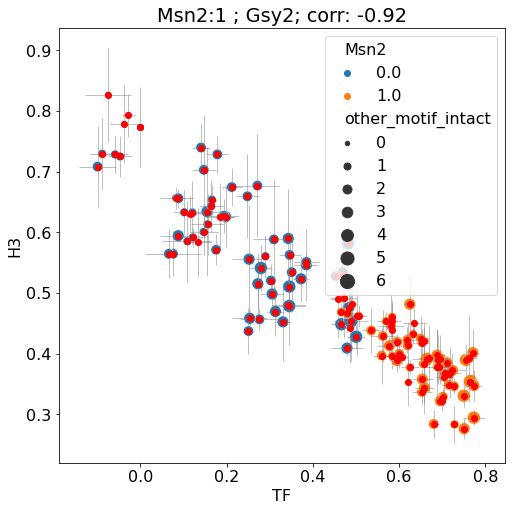

In [9]:
tf='Msn2'
tp='180'
lib_num = '32'
lib_num_int = int(lib_num)
exp_num_h3 = '31'
exp_num_tf = '13'
lib_info = dp.get_lib_info(lib_num)
gene = lib_info['gene'].upper()
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
mut_var_seq = lto.get_mut_var(lib_num)
fig, curr_ax = plt.subplots(1, 1, figsize=(8,8))

# normlize nucs
norm_0_h3 = lto.norm_without_biorep_mean('H3', lib_num, exp_num_h3, 0, occ=None) # normlize data
norm_wt = norm_0_h3 - (norm_0_h3.loc[wt_var_seq])    
norm_nuc = 1/2**norm_wt* params.LIB_NUC_NORM.query("Lib_num == @lib_num_int")['Ratio'].values[0]
mean_res_h3 = dp.mean_over_bio_reps(norm_nuc)[tp]      ##################
sem_h3 = dp.sem_over_bio_reps(norm_nuc)[tp]

#normzlize tf
norm_uncut_tf = lto.norm_without_biorep_mean(tf, lib_num, exp_num_tf, None, occ=True) # normlize data
mean_res_tf = dp.mean_over_bio_reps(norm_uncut_tf)[tp]      ##################
sem_tf = dp.sem_over_bio_reps(norm_uncut_tf)[tp]

#combine H3 and TF data to df
exp_comp_df = pd.concat([mean_res_tf, mean_res_h3],axis=1)
exp_comp_df.columns = ['TF', 'H3'] 
exp_comp_df['H3_sem'] = sem_h3
exp_comp_df['TF_sem'] = sem_tf

# get TF motif ranks within libraries
tf_ranks=[]
for i, row in params.LIB_MOT_RANK.query("lib==@lib_num_int and tf==@tf").iterrows():
    tf_ranks.append(row['tf'] + ':' + str(i))
', '.join(tf_ranks)

corr_val = str(np.round(exp_comp_df.corr().values[1][0],2)) #correlation between TF and H3

#### scatters comparing plasmid to Nucleosome

seqs = exp_comp_df.index # library sequences
all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences splited
tf_intact_motif_seqs = np.zeros((len(seqs),1)) 
tf_pos = lto.get_tf_mot_pos(tf,lib_num) #get tf library positions
for pos in tf_pos:#iterate over tf postion
    tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos]] += 1 # count number of tf motif in seq
exp_comp_df[tf] = tf_intact_motif_seqs 

intact_pos = np.zeros((len(seqs),len(list(wt_var_seq)))) 
for pos_i, pos in enumerate(list(wt_var_seq)): # count other motifs intact in seqs
    intact_pos[:,pos_i] = all_seqs_split[:,pos_i] == pos
exp_comp_df['other_motif_intact'] = np.reshape(np.sum(intact_pos, axis=1), (len(seqs),1)) - tf_intact_motif_seqs


sns.scatterplot(data=exp_comp_df, x='TF', y='H3', hue=tf,
                size='other_motif_intact' ,sizes=(20,200), ax=curr_ax)
curr_ax.errorbar(exp_comp_df['TF'], exp_comp_df['H3'], xerr=exp_comp_df['TF_sem'],
             yerr=exp_comp_df['H3_sem'],ecolor='grey',elinewidth=0.5, color='r', fmt='o')

plt.scatter(x=exp_comp_df['TF'].loc[wt_var_seq], y=exp_comp_df['H3'].loc[wt_var_seq], color='k')
plt.scatter(x=exp_comp_df['TF'].loc[mut_var_seq], y=exp_comp_df['H3'].loc[mut_var_seq], color='k')


curr_ax.set_title(', '.join(tf_ranks) + ' ; ' + lib_info['gene'] + '; corr: ' + corr_val)

## (H) Msn2 dependent nucleosome eviction

In [10]:
datasets = [MNASE_ddmsn, MNASE, ATAC, ATAC_ddmsn]
datasets_names = ['MNase', 'MNase', 'atac', 'atac']
h3_libs = [f.split('_')[1] for f in dp.find_tf_files('H3')]
msn2_libs = [f.split('_')[1] for f in dp.find_tf_files('Msn2')]
h3_msn2_libs = np.intersect1d(h3_libs,msn2_libs) # Msn2 libraries measured in H3-MNase

msn2_libs_fc = pd.DataFrame()
for lib_i, lib_num in enumerate(h3_msn2_libs): # iterate over libraries
    lib_info = dp.get_lib_info(lib_num) # library information
    gene = lib_info['gene'].upper() # current gene
    curr_lib_locs = params.LIB_LOCS.loc[int(lib_num)] # library genomic location
    curr_chr = curr_lib_locs['Chromosome'] 
    lib_start_id = curr_lib_locs['Lib_start']
    lib_end_id = curr_lib_locs['Lib_end']
    for dic_i in np.arange(0,4,2): # iterate over datasets
        for i in range(2):
            lib_data_dict1 = np.log2(datasets[dic_i][curr_chr]['rep'+str(i+1)][lib_start_id:lib_end_id]+1) # get wt and ddmsn2 data in current repeat
            lib_data_dict2 = np.log2(datasets[dic_i+1][curr_chr]['rep'+str(i+1)][lib_start_id:lib_end_id]+1)
            if datasets_names[dic_i]=='atac': 
                lib_data_dict1 = gf.smooth(lib_data_dict1,20)
                lib_data_dict2 = gf.smooth(lib_data_dict2,20)
            rep_fc = lib_data_dict1 - lib_data_dict2 # clculate FC for current repeat
            rep_fc_mean = np.mean(rep_fc)
            msn2_libs_fc = pd.concat([msn2_libs_fc, pd.DataFrame({'Dataset': [datasets_names[dic_i]],'Lib': [lib_num],
                                                                  'FC': [rep_fc_mean], 'Repeat': [str(i+1)]})])
msn2_mean_libs_fc = pd.DataFrame()

titles = ['MNase', 'ATAC']
for di, dataset in enumerate(['MNase', 'atac']): # get the mean and std FC for 2 repeat in datasets
    FC_mean = msn2_libs_fc.query("Dataset == @dataset").groupby('Lib')['FC'].mean()
    FC_std = msn2_libs_fc.query("Dataset == @dataset").groupby('Lib')['FC'].std()
    dataset_vals = pd.concat([FC_mean,FC_std],axis=1)
    dataset_vals.columns = ['FC_mean','FC_std']
    dataset_vals['Dataset'] = np.repeat(dataset,dataset_vals.shape[0])
    dataset_vals['lib_name'] = [dp.get_lib_info(lib)['gene'] for lib in h3_msn2_libs]
    msn2_mean_libs_fc = pd.concat([msn2_mean_libs_fc,dataset_vals])


In [11]:
tp='180'
tf='Msn2'
exps = ['13','26']
effect_tresh=0.1
for lib_i, lib_num in enumerate(h3_msn2_libs):  
    lib_info = dp.get_lib_info(lib_num) # get library info
    gene = lib_info['gene'].upper() # gene name
    wt_var_seq = ''.join(lib_info['wt_at_var_loc']) # wt seq
    mut_var_seq = lto.get_mut_var(lib_num) # mutated seq
    # normlize H3 data
    norm_tp_0 = lto.norm_without_biorep_mean('H3', lib_num, exp_num_h3, 0, occ=None) # normlize data

    #Msn2 effective positions
    norm_df = lto.convert_fc_to_occ(lto.combine_2_exps(tf, lib_num, tp, exps, norm_to=None))
    single_pos_effect,_ = lto.only_pos_intact_change_calc(tf, lib_num, exp_num=None, norm_to=None, occ=None, norm_df=norm_df)
    tf_pos, non_tf_pos = lto.get_tf_positions(lib_info, tf)
    effective_pos = np.where(single_pos_effect.loc[tp] > effect_tresh)[0]

    other_tf_pos=[] # other tf positions that are not effective
    if len(effective_pos)!=len(tf_pos):
        for pos in tf_pos:
            if pos in effective_pos:
                effective_pos = np.delete(effective_pos, np.where(effective_pos==pos)[0])
        other_tf_pos = effective_pos

    # for each sequence count: TF motifs and other TF motifs
    seqs = norm_df.index # library sequences
    all_seqs_split = np.array([list(seq) for seq in seqs]) 
    tf_intact_motif_seqs = np.zeros((len(seqs),len(tf_pos)))
    for i, pos in enumerate(tf_pos):
        tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    norm_df['TF_motif'] = np.sum(tf_intact_motif_seqs, axis=1)
    
    other_tf_mot_count = np.zeros((len(seqs),len(other_tf_pos)))
    for i, pos in enumerate(other_tf_pos):
        other_tf_mot_count[all_seqs_split[:,pos]==wt_var_seq[pos], i] = 1
    other_mot_count = np.sum(other_tf_mot_count, axis=1)

    norm_df['other_mot_count'] = other_mot_count
    msn2_cnonical_motifs = norm_df['TF_motif'].max()
    msn2_noncnonical_motifs = norm_df['other_mot_count'].max()
    
    # seqs including effective motifs 
    effective_seqs = norm_df.query("TF_motif==@msn2_cnonical_motifs & other_mot_count==@msn2_noncnonical_motifs").index
    # seqs not including effective motifs 
    non_effective_seqs = norm_df.query("TF_motif==0 & other_mot_count==0").index
    
    #calculate fold change between effective and non effective sequences mean
    effctiv_pos_fc = norm_tp_0.loc[effective_seqs].mean(axis=0) - norm_tp_0.loc[non_effective_seqs].mean(axis=0)
    effctiv_pos_fc_mean = effctiv_pos_fc.mean()
    effctiv_pos_fc_std = effctiv_pos_fc.std()
    
    #get FC between wt to mut seq
    h3_fc = norm_tp_0.loc[wt_var_seq] - norm_tp_0.loc[mut_var_seq]
    h3_mean_fc = h3_fc.mean()
    h3_std_fc = h3_fc.std()
    h3_lib_fc = pd.DataFrame({"Lib":[lib_num],'FC_mean':[h3_mean_fc],
                              'FC_std':[h3_std_fc],'Dataset':['H3'],
                              'TF_pos_mean':effctiv_pos_fc_mean, 'TF_pos_std':effctiv_pos_fc_std,
                              'lib_name':[lib_info['gene']]})
    h3_lib_fc.set_index('Lib',inplace=True)
    msn2_mean_libs_fc = pd.concat([msn2_mean_libs_fc,h3_lib_fc])

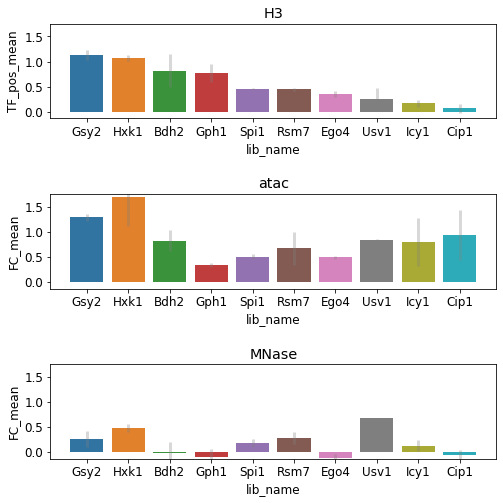

In [12]:
plt.rcParams.update({'font.size': 12})

h3_vals = msn2_mean_libs_fc.query("Dataset=='H3'")
h3_vals = h3_vals.sort_values(by='TF_pos_mean', ascending=False)
f,axes = plt.subplots(3,1,figsize=(8,8), sharey=True)
plt.subplots_adjust(hspace = 0.8)

for di, dataset in enumerate(['H3', 'atac','MNase']):
    curr_ax = axes[di]
    dataset_vals = msn2_mean_libs_fc.query("Dataset==@dataset").loc[h3_vals.index.values]
    if dataset == 'H3':
        sns.barplot(data=dataset_vals, x='lib_name', y='TF_pos_mean', ax=curr_ax)
        curr_ax.errorbar(data=dataset_vals, x='lib_name', y='TF_pos_mean',yerr='TF_pos_std',
                         ls='', lw=3, color='grey', alpha=0.3)
    else:
        sns.barplot(data=dataset_vals, x='lib_name', y='FC_mean', ax=curr_ax)    
        curr_ax.errorbar(data=dataset_vals, x='lib_name', y='FC_mean',yerr='FC_std',
                         ls='', lw=3, color='grey', alpha=0.3)
    
   
    curr_ax.set_title(dataset)
    curr_ax.set_ylim(-0.135,1.75)
    curr_ax.set_yticks(np.arange(0,2,0.5))


## (I) Msn2 cooperativity scores

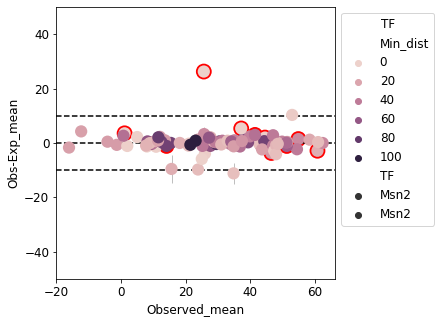

In [13]:
tf = 'Msn2'
tf_split =  re.findall('\d*\D+',tf)[0]
tf_data = all_tf_coop.query("TF==@tf")
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=tf_data, x='Observed_mean', y='Obs-Exp_mean', hue='Min_dist',style='TF', s=150, zorder=20, linewidth=0, ax=ax)
plt.errorbar(tf_data['Observed_mean'], tf_data['Obs-Exp_mean'], yerr=tf_data['Obs-Exp_sem'],
             ecolor='grey',elinewidth=0.5, fmt='o')
self_df = tf_data.query("Comb_type=='Self_comb'")
sns.scatterplot(data=self_df, x='Observed_mean', y='Obs-Exp_mean', color='r',style='TF', s=250, linewidth=0, ax=ax)
ax.set_ylim(-50,50)
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))